## Libraries

In [1]:
import pandas                  as pd
import matplotlib.pyplot       as plt
import seaborn                 as sns
import numpy                   as np
from itertools                 import count
from sklearn.metrics.pairwise  import euclidean_distances
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.metrics           import accuracy_score, confusion_matrix
from sklearn.naive_bayes       import GaussianNB
from sklearn.preprocessing     import StandardScaler, Normalizer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics           import mean_squared_error
from scipy.signal              import savgol_filter
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

#### Understanding the data

##### Read the data

In [8]:
data = pd.read_csv('data/drought_forecasting.csv', dayfirst=True, parse_dates =["date"], index_col ="date")
data

,PRECTOT,PS,T2M,T2MDEW,T2MWET,TS,QV2M
date,,,,,,,
2000-01-01,0.22,100.51,14.74,13.51,13.51,14.65,9.65
2000-01-02,0.20,100.55,16.69,14.71,14.71,16.60,10.42
2000-01-03,3.65,100.15,18.49,16.52,16.52,18.41,11.76
2000-01-04,15.95,100.29,11.40,6.09,6.10,11.31,6.42
2000-01-05,0.00,101.15,3.86,-3.29,-3.20,2.65,2.95
...,...,...,...,...,...,...,...
2020-12-27,0.00,100.73,3.50,0.87,2.18,3.32,4.03
2020-12-28,0.05,101.07,7.20,6.39,6.80,6.95,5.95
2020-12-29,0.11,101.10,10.01,8.78,9.39,9.96,7.01


##### Missing values

In [132]:
nullValues = data.isnull().sum()
nullValues

PRECTOT    0
PS         0
T2M        0
T2MDEW     0
T2MWET     0
TS         0
QV2M       0
dtype: int64

##### Data types and data summary

In [133]:
data.head()

,PRECTOT,PS,T2M,T2MDEW,T2MWET,TS,QV2M
date,,,,,,,
2000-01-01,0.22,100.51,14.74,13.51,13.51,14.65,9.65
2000-01-02,0.20,100.55,16.69,14.71,14.71,16.60,10.42
2000-01-03,3.65,100.15,18.49,16.52,16.52,18.41,11.76
2000-01-04,15.95,100.29,11.40,6.09,6.10,11.31,6.42
2000-01-05,0.00,101.15,3.86,-3.29,-3.20,2.65,2.95


In [134]:
data.describe()
# looking the data description is already possible to see that aggregate the data could be not so good, 
# because there is a high value in PRECTOT that can be an outliers and will 'desapear' in the aggregation process.
# So use the atomic granularity possibly is the best option

,PRECTOT,PS,T2M,T2MDEW,T2MWET,TS,QV2M
count,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000
mean,3.718138,100.283734,17.687126,12.902799,12.895320,17.585104,10.447320
std,8.118149,0.497352,8.444942,8.096155,8.066492,8.532297,4.686545
min,0.000000,97.970000,-6.490000,-15.450000,-14.520000,-8.360000,1.040000
25%,0.000000,99.960000,11.240000,6.980000,6.970000,11.030000,6.320000
50%,0.220000,100.240000,18.830000,14.690000,14.650000,18.700000,10.510000
75%,3.545000,100.580000,25.160000,19.840000,19.820000,25.140000,14.540000
max,137.590000,102.470000,32.970000,24.810000,24.810000,33.450000,19.790000


In [135]:
data.dtypes

PRECTOT    float64
PS         float64
T2M        float64
T2MDEW     float64
T2MWET     float64
TS         float64
QV2M       float64
dtype: object

In [13]:
"""data['day'] = pd.DatetimeIndex(data['date'], dayfirst=True).day
data['month'] = pd.DatetimeIndex(data['date'], dayfirst=True).month
data['year'] = pd.DatetimeIndex(data['date'], dayfirst=True).year
data = data[[col for col in data if col not in ['QV2M']] + ['QV2M']]
data.pop('date')"""

0       01/01/2000
1       02/01/2000
2       03/01/2000
3       04/01/2000
4       05/01/2000
           ...    
7666    27/12/2020
7667    28/12/2020
7668    29/12/2020
7669    30/12/2020
7670    31/12/2020
Name: date, Length: 7671, dtype: object

#### 1. Data Profiling

##### 1.1. Data Granularity 

###### 1.1.1. Resample

In [9]:
# Granularity: atomic (daily)
daily_data = data
# Granularity: weekly
weekly_data = data.resample('W').mean()
# Granularity: monthly
monthly_data = data.resample('M').mean()

In [7]:
monthly_data

,PRECTOT,PS,T2M,T2MDEW,T2MWET,TS,QV2M
date,,,,,,,
2000-01-31,3.756452,100.720968,7.451613,3.638387,3.687097,7.285806,5.651290
2000-02-29,1.563793,100.782069,10.691034,6.241034,6.259655,10.386897,6.479310
2000-03-31,3.954194,100.232258,14.642903,10.169677,10.176452,14.408387,8.147742
2000-04-30,3.585000,100.174667,15.856333,11.010667,11.015333,15.720333,8.562000
2000-05-31,1.196129,100.109677,24.050645,15.852581,15.854839,24.188065,11.583548
...,...,...,...,...,...,...,...
2020-08-31,3.330645,99.946129,27.282903,21.410968,21.265161,27.404839,16.016129
2020-09-30,2.561667,100.088333,23.751000,18.062667,17.912000,23.854333,13.174667
2020-10-31,4.426774,100.227742,19.453548,14.762581,14.569355,19.425806,10.908065


##### 1.2. Data Distribution and Stationarity  

###### 1.2.1. Boxplots

In [137]:
def boxplot(data, filename):
    """"""

    fig, ax = plt.subplots()
    sns.boxplot(data=data)
    plt.savefig('plots/'+filename + ".png")
    plt.close()

In [138]:
boxplot(daily_data, 'boxplot_drought_forecasting_dailySeparated')
boxplot(weekly_data, 'boxplot_drought_forecasting_weeklySeparated')
boxplot(monthly_data, 'boxplot_drought_forecasting_monthlySeparated')

###### 1.2.2. Histograms 

In [139]:
def histograms(data, filename, dimension):
    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(24, 14))
    
    for position in range(len(data.columns)):
        col = data.columns[position]

        pos_i = position//j
        pos_j = position%j

        ax[pos_i][pos_j].hist(data[col])
        ax[pos_i][pos_j].set_title(col)
        ax[pos_i][pos_j].legend()
        
    plt.savefig('plots/' + filename + '.png')
    plt.close()

In [ ]:
histograms(daily_data, 'hist_drought_forecasting_dailySeparated', (2, 4))
histograms(weekly_data, 'hist_drought_forecasting_weeklySeparated', (2, 4))
histograms(monthly_data, 'hist_drought_forecasting_monthlySeparated', (2, 4))

###### 1.2.3. Stationarity

In [145]:
def plot_stationarity(data, filename, dimension):
    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(24, 14))
    
    for position in range(len(data.columns)):
        col = data.columns[position]

        pos_i = position//j
        pos_j = position%j

        ax[pos_i][pos_j].plot(data[col])
        ax[pos_i][pos_j].set_title(col)
        ax[pos_i][pos_j].legend()
        
    plt.savefig('plots/' + filename + '.png')
    plt.close()
    

In [ ]:
plot_stationarity(daily_data, 'stationarity_drought_forecantig_dailySeparated', (2, 4))
plot_stationarity(weekly_data, 'stationarity_drought_forecantig_weeklySeparated', (2, 4))
plot_stationarity(monthly_data, 'stationarity_drought_forecantig_monthlySeparated', (2, 4))

In [10]:
def temporal_data_split_forPersistence(data, train_size=0.80):

    data = pd.DataFrame(data)
    lim = round(len(data)*train_size)

    tmp_data_x = data.shift(1)
    X_train = tmp_data_x.iloc[1:lim]
    X_test = tmp_data_x.iloc[lim:]
    Y_train = data.iloc[1:lim]
    Y_test = data.iloc[lim:]
    return X_train, X_test, Y_train, Y_test

In [11]:
# persistence model
def model_persistence(x):
    return x

In [12]:
def persistence_model(X_test, Y_test):

   predictions = []
   for x in np.array(X_test):
      yhat = model_persistence(x)
      predictions.append(yhat)
      
   rmse = (mean_squared_error(Y_test, predictions))**(1/2)
   res = [Y_test, pd.DataFrame(predictions, index=X_test.index)]
   return res, rmse

In [359]:
"""def plot_persistence(dataTrain, data, columns,  filename, dimension):
    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(35, 25))
    
    for position in range(len(columns)):
        col = columns[position]

        pos_i = position//j
        pos_j = position%j

        ax[pos_i][pos_j].plot(data[position][0], color = "red")
        ax[pos_i][pos_j].plot(data[position][1], color = "green")
        ax[pos_i][pos_j].plot(dataTrain[col], color = "blue")
        plt.legend(col)
        plt.xticks(rotation=45)

    plt.savefig('plots/' + filename + '.png')"""

In [28]:
def plot_persistence(X_train, Y_test, Y_pred,  filename):
    plt.plot(Y_test, color = "red")
    plt.plot(Y_pred, color = "green")
    plt.plot(X_train, color = "blue")
    plt.legend(['Test', 'Pred', 'Train'])
    plt.savefig('plots/' + filename + '.png')

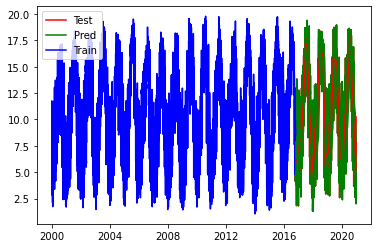

In [31]:
data_daily_persistenceRes = []
data_weekly_persistenceRes = []
data_monthly_persistenceRes = []

"""X_train_d, X_test_d, Y_train_d, Y_test_d = 0,0,0,0
X_train_w, X_test_w, Y_train_w, Y_test_w = 0,0,0,0
X_train_m, X_test_m, Y_train_m, Y_test_m = 0,0,0,0"""

stats_ps = pd.DataFrame(columns=['var', 'rmse - daily', 'rmse - weekly', 'rmse - monthly'])

c = 0
for col in daily_data.columns:

    X_train_d, X_test_d, Y_train_d, Y_test_d = temporal_data_split_forPersistence(daily_data[col])
    X_train_w, X_test_w, Y_train_w, Y_test_w = temporal_data_split_forPersistence(weekly_data[col])
    X_train_m, X_test_m, Y_train_m, Y_test_m = temporal_data_split_forPersistence(monthly_data[col])

    res_ps_daily, rmse_ps_daily = persistence_model(X_test_d, Y_test_d)
    res_ps_weekly, rmse_ps_weekly = persistence_model(X_test_w, Y_test_w)
    res_ps_monthly, rmse_ps_monthly = persistence_model(X_test_m, Y_test_m)

    data_daily_persistenceRes.append(res_ps_daily)
    data_weekly_persistenceRes.append(res_ps_weekly)
    data_monthly_persistenceRes.append(res_ps_monthly)

    stats_ps.loc[c] = [col, rmse_ps_daily, rmse_ps_weekly, rmse_ps_monthly]

    if col == "QV2M":
        plot_persistence(Y_train_d, Y_test_d, res_ps_daily[1], 'drought_forecasting_persistence_daily1')
        plot_persistence(Y_train_w, Y_test_w, res_ps_weekly[1], 'drought_forecasting_persistence_weekly1')
        plot_persistence(Y_train_m, Y_test_m, res_ps_monthly[1], 'drought_forecasting_persistence_monthly1')
    
    c+=1

In [32]:
stats_ps

,var,rmse - daily,rmse - weekly,rmse - monthly
0,PRECTOT,10.391203,5.233767,2.573231
1,PS,0.368760,0.379476,0.236102
2,T2M,2.866278,3.447826,4.583121
3,T2MDEW,3.975010,4.173226,4.257871
4,T2MWET,3.933644,4.114139,4.223295
5,TS,2.859072,3.471627,4.637605
6,QV2M,2.110591,2.249964,2.459044


In [53]:
# smoothing
def smooth_sg1(data, frac, p, filename, dimension):

    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(35, 25))
    data_filtered1 = []
    for pos in range(len(data.columns)):
        x = data[data.columns[pos]]
        w = int(len(x)*frac)
        x_filtered = savgol_filter(x, w, p)
        data_filtered1.append(x_filtered)
        data_filtered = pd.DataFrame(data=x_filtered, index=data.index)

        pos_i = pos//j
        pos_j = pos%j

        ax[pos_i][pos_j].plot(x, color='grey')
        ax[pos_i][pos_j].plot(data_filtered, color = "green")
        plt.legend(x)
        #plt.xticks(rotation=45)

    
    plt.savefig('plots/' + filename + '.png')
    return data_filtered1

In [42]:
def ses(data, s_level, filename, dimension):

    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(35, 25))
    data_filtered = []
    

    for pos in range(len(data.columns)):

        x = data[data.columns[pos]]
        model = SimpleExpSmoothing(x)
        x_filtered = model.fit(smoothing_level=s_level, optimized=False)
        print(x_filtered)
        data_filtered.append(x_filtered.fittedvalues)

        pos_i = pos//j
        pos_j = pos%j

        ax[pos_i][pos_j].plot(x, color='grey')
        ax[pos_i][pos_j].plot(x_filtered.fittedvalues, color = "green")
        plt.legend(x)
        #plt.xticks(rotation=45)

    
    plt.savefig('plots/' + filename + '.png')
    return data_filtered

/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferre

/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferre

/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lidiana/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferre

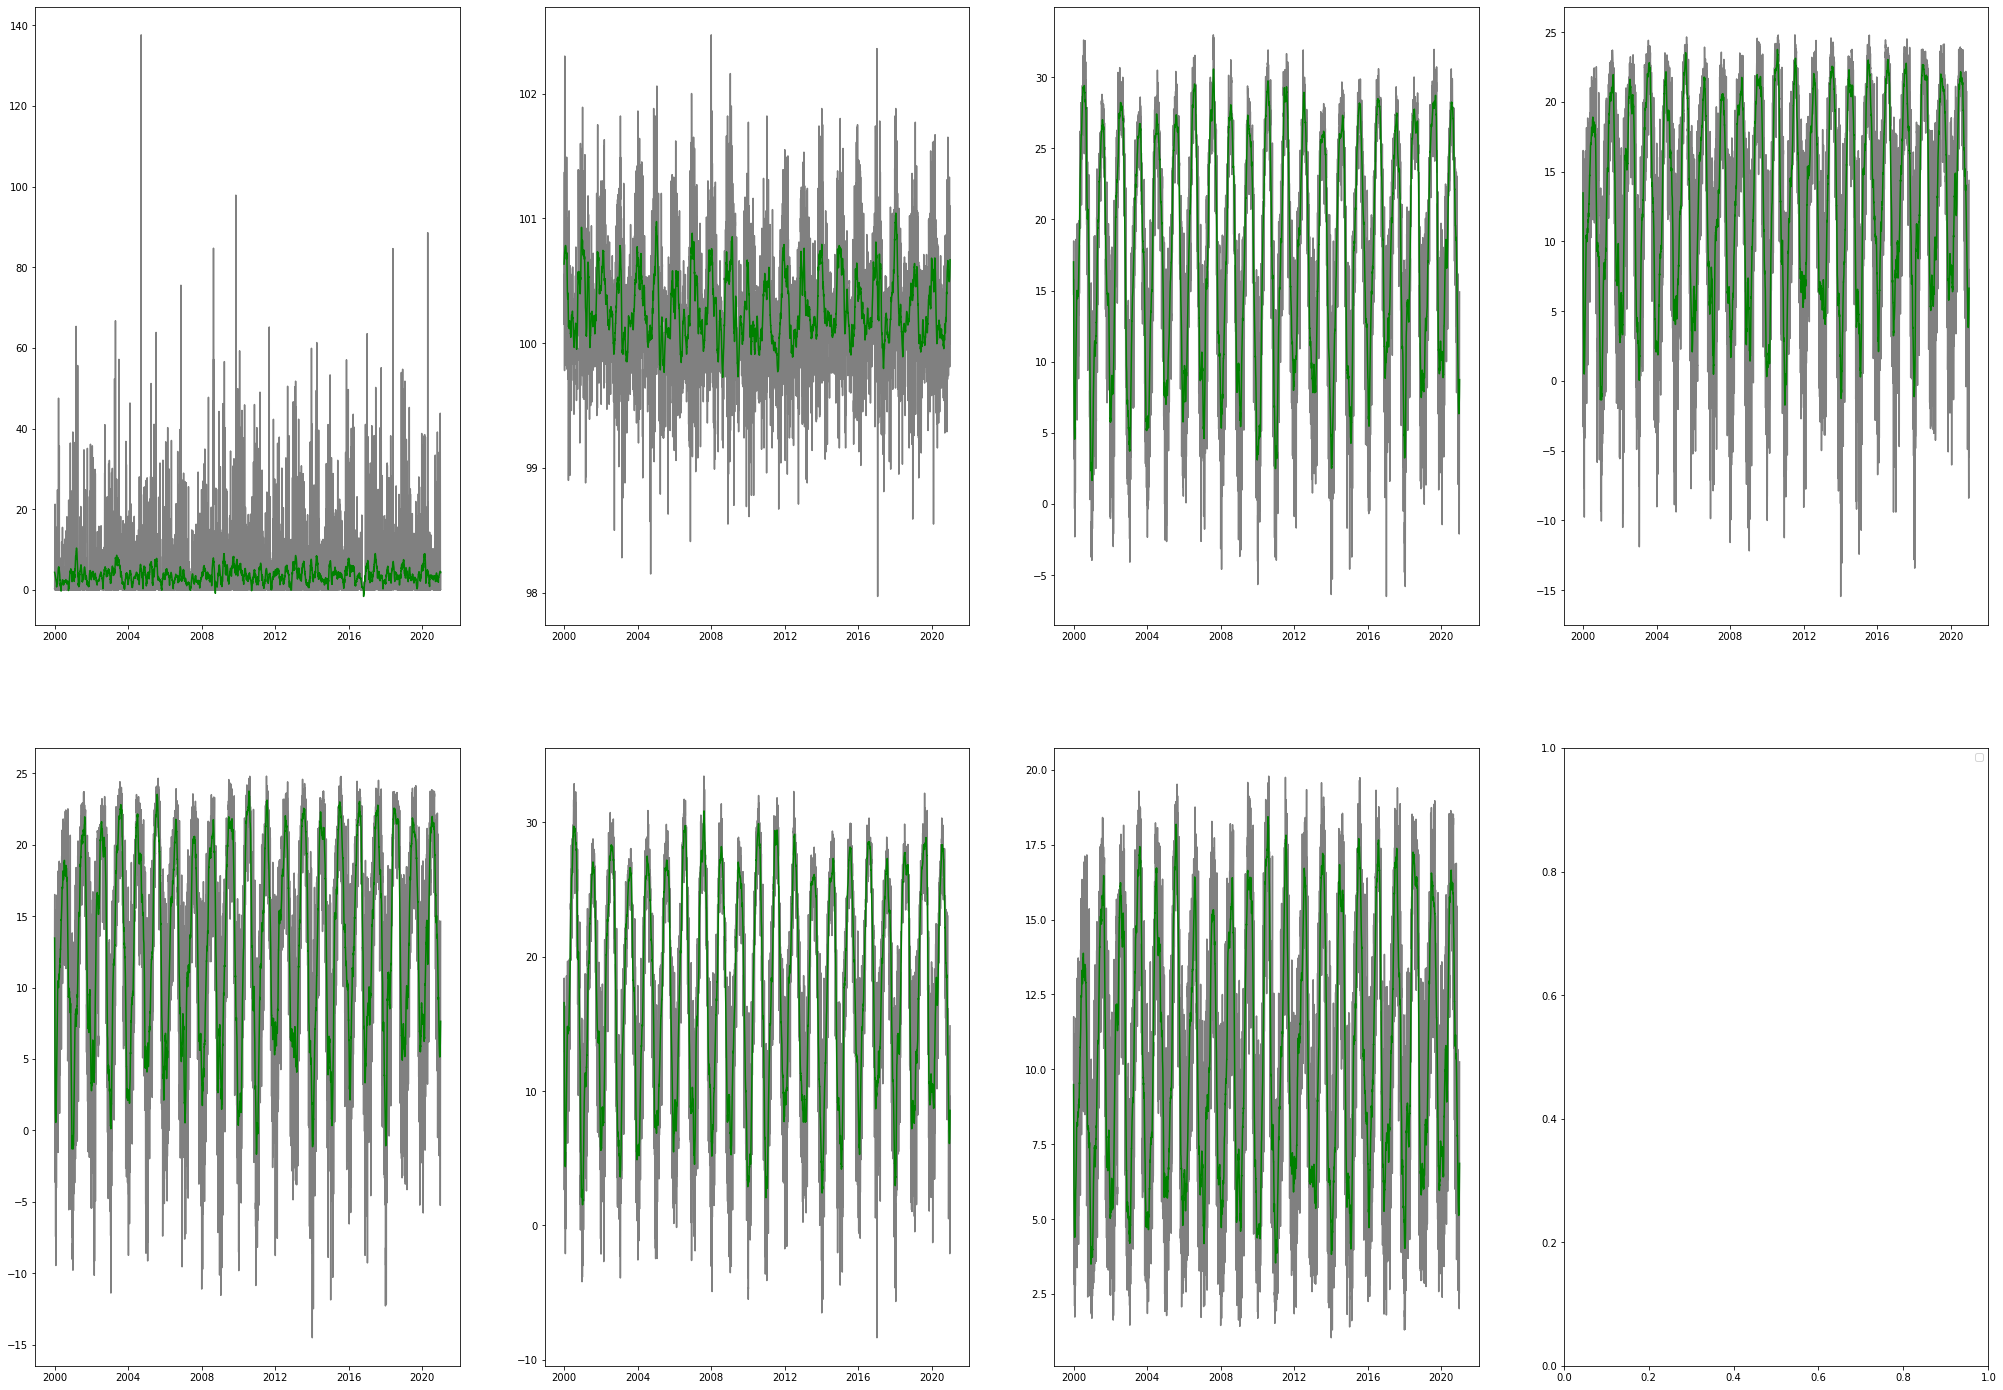

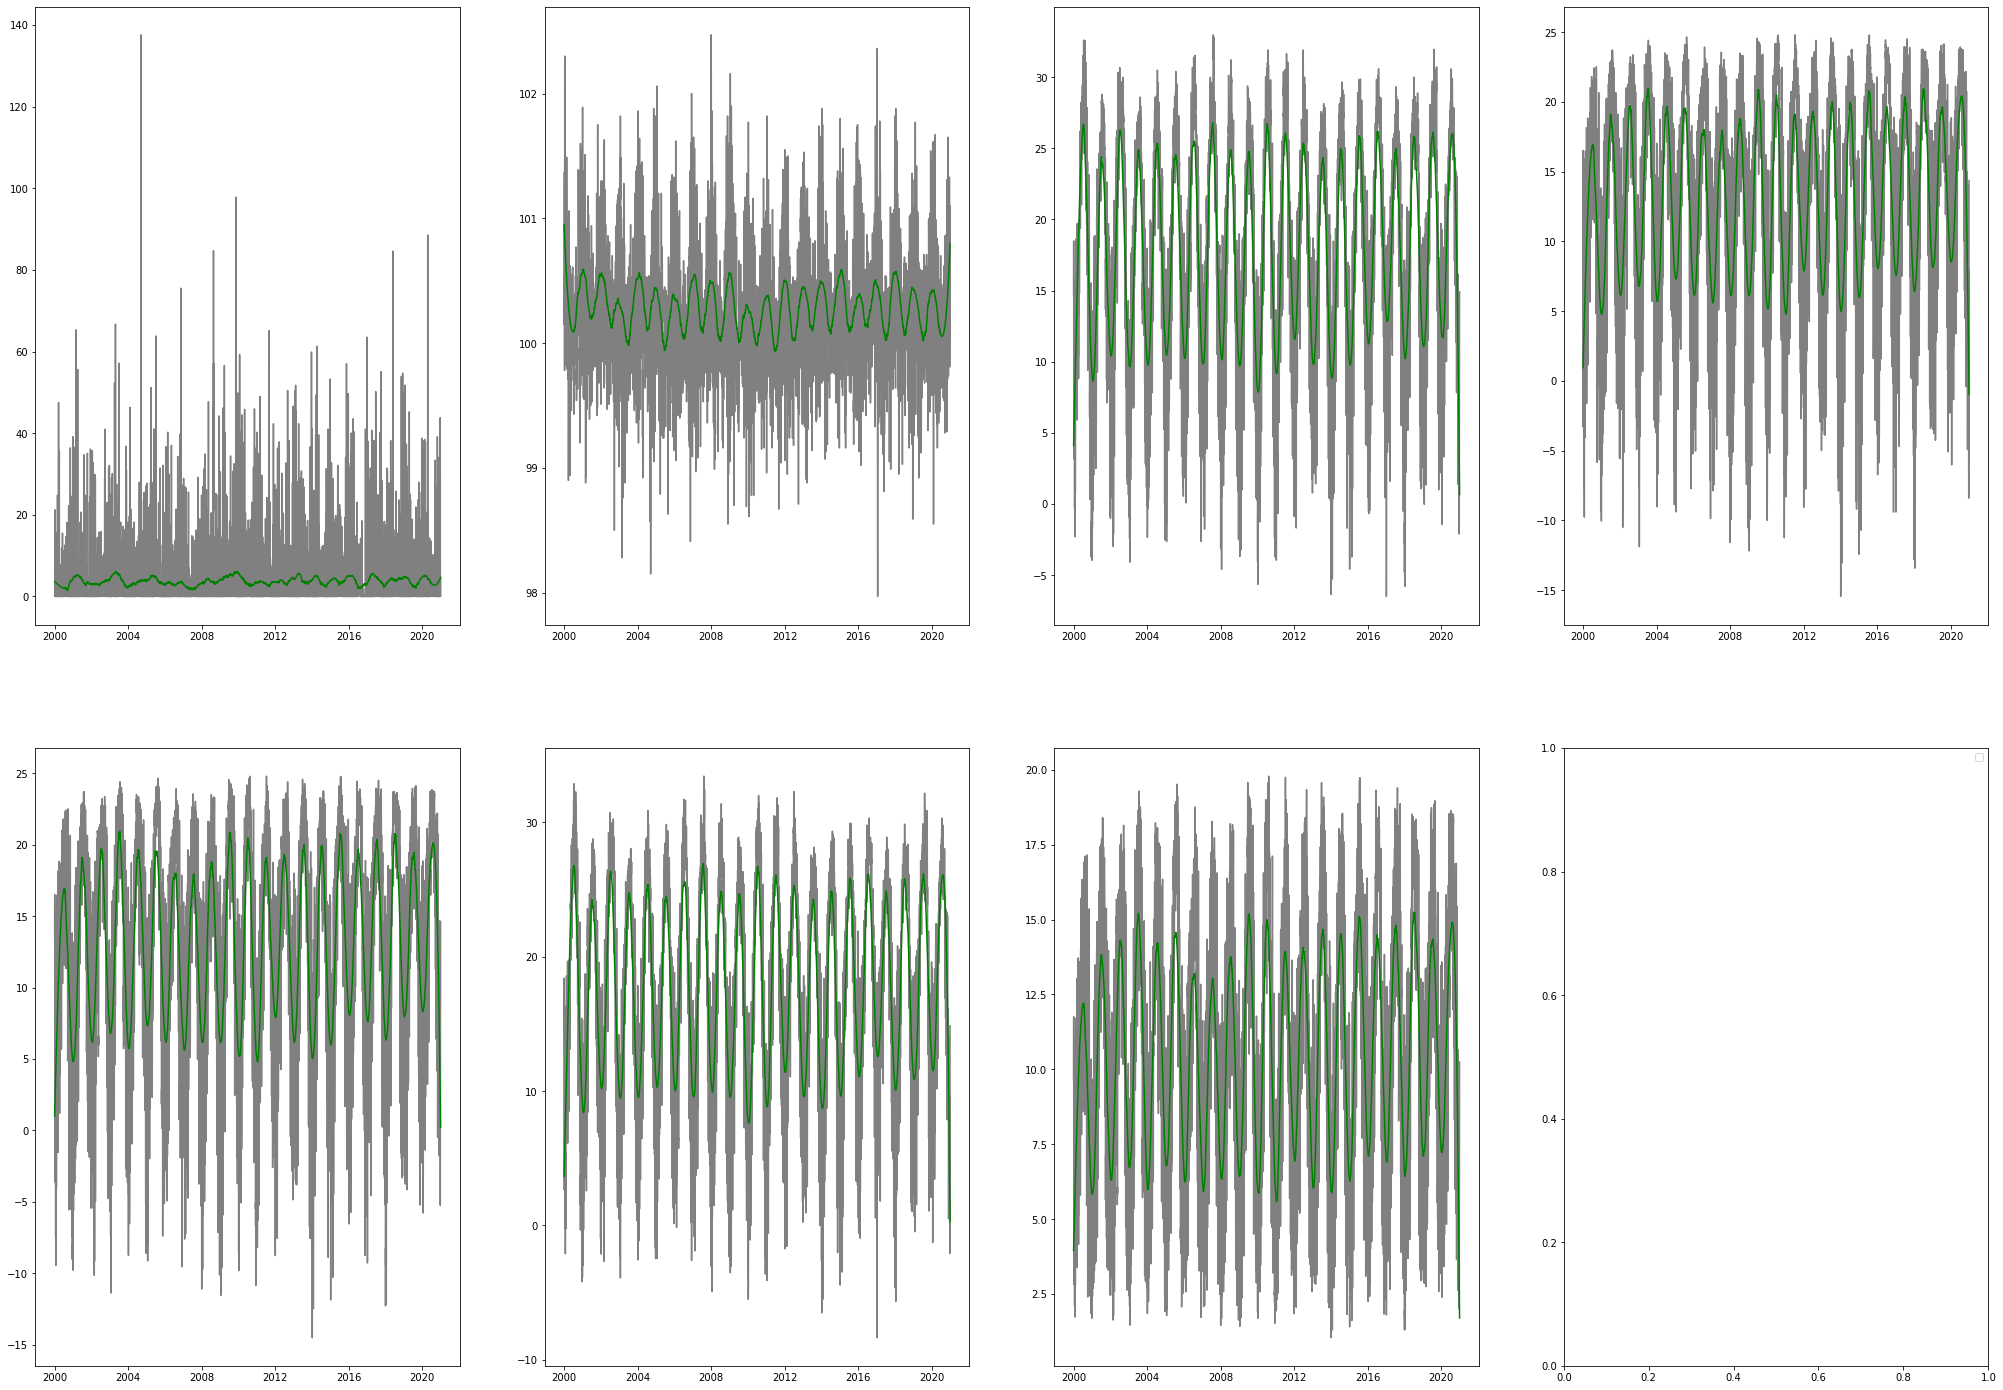

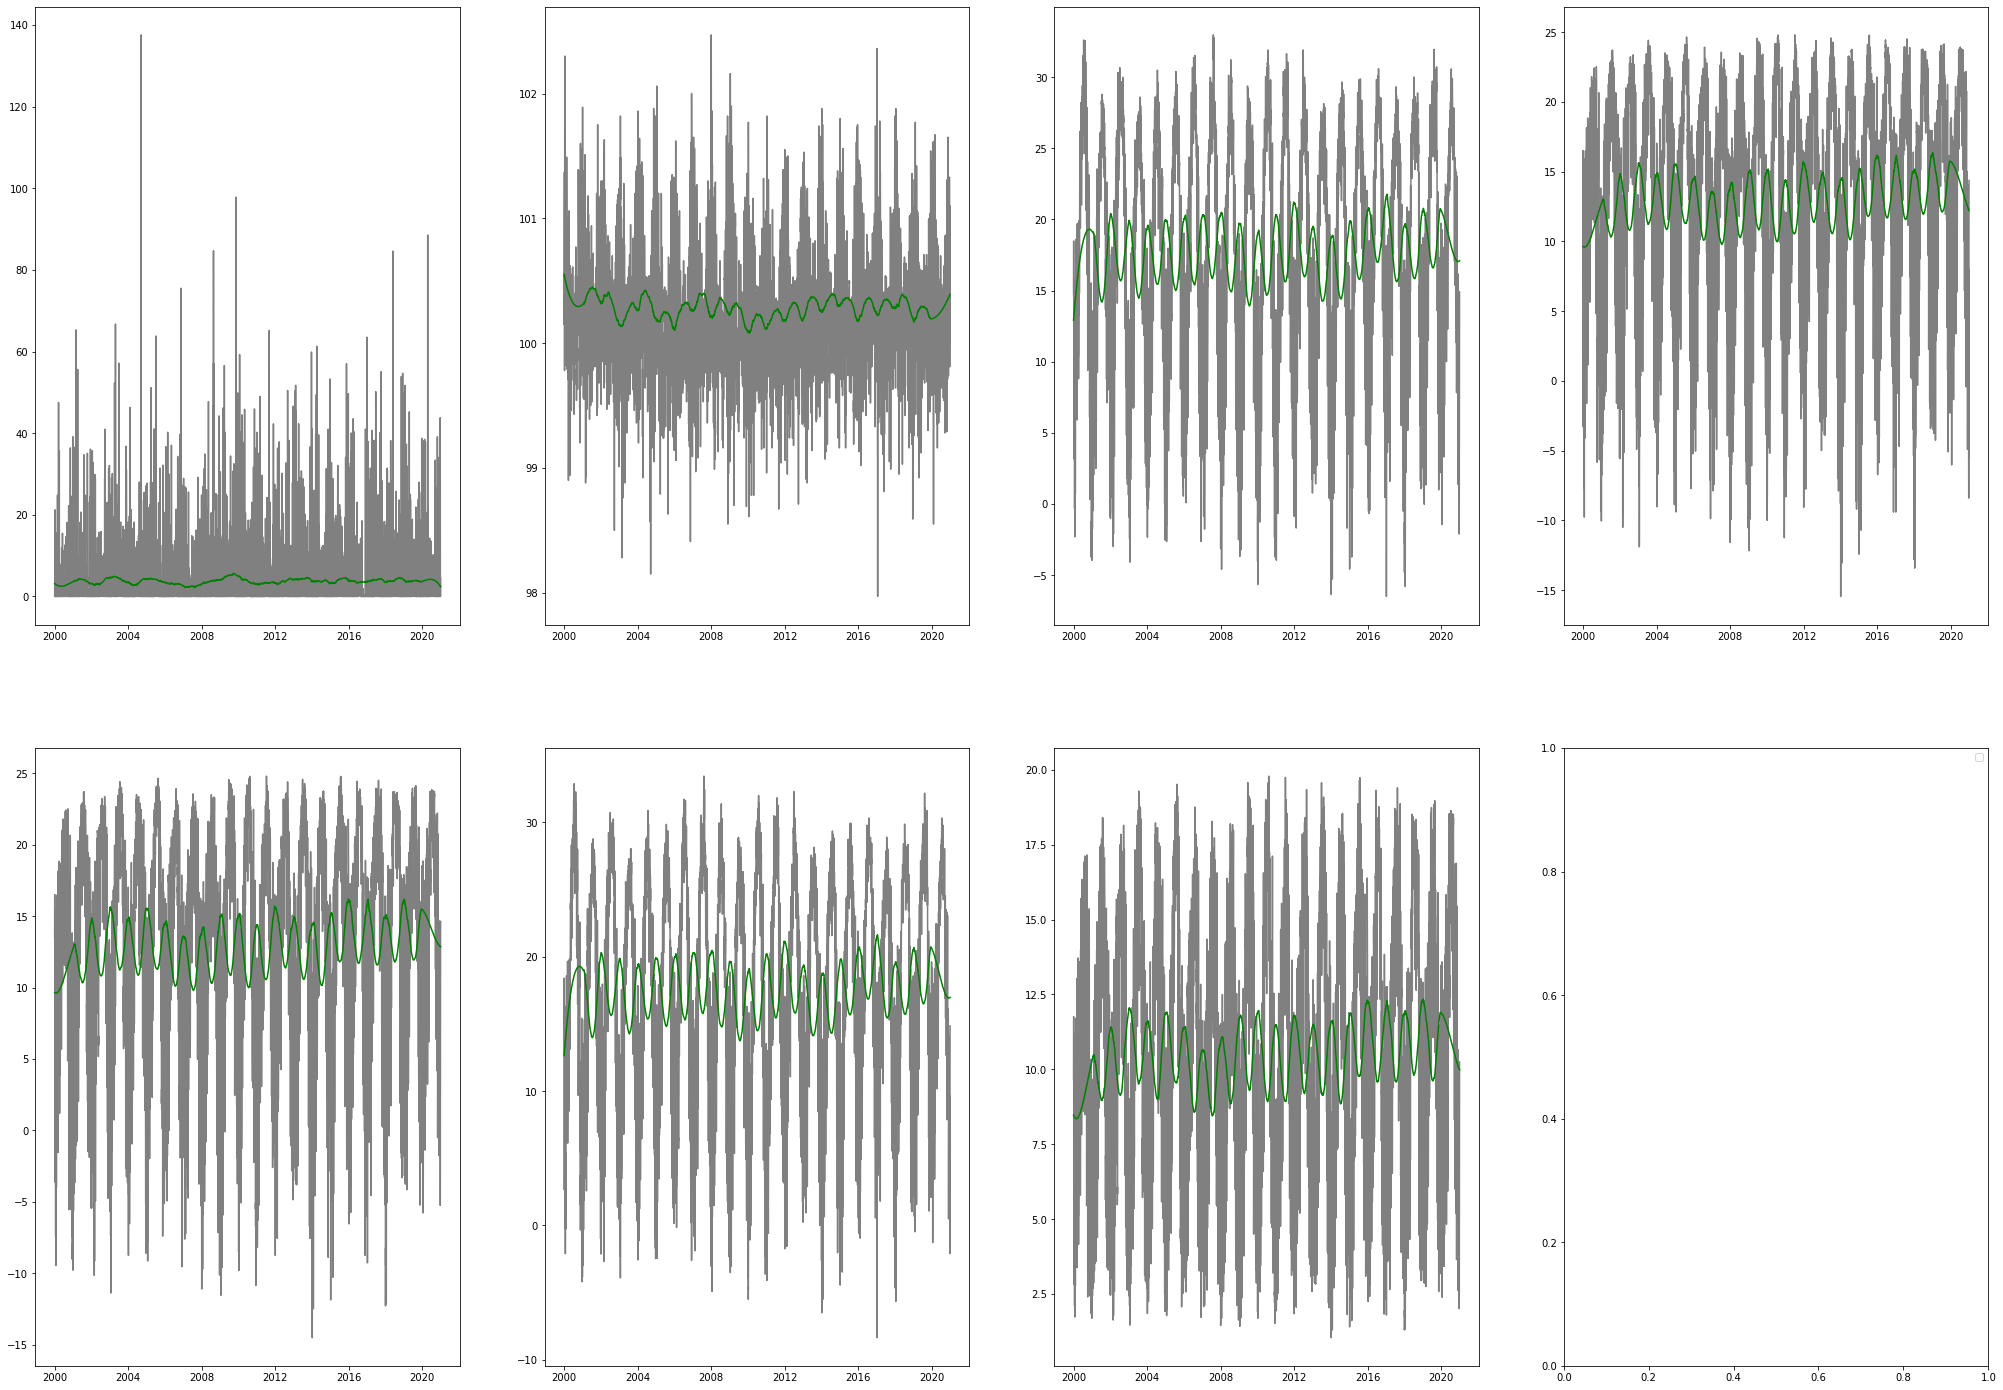

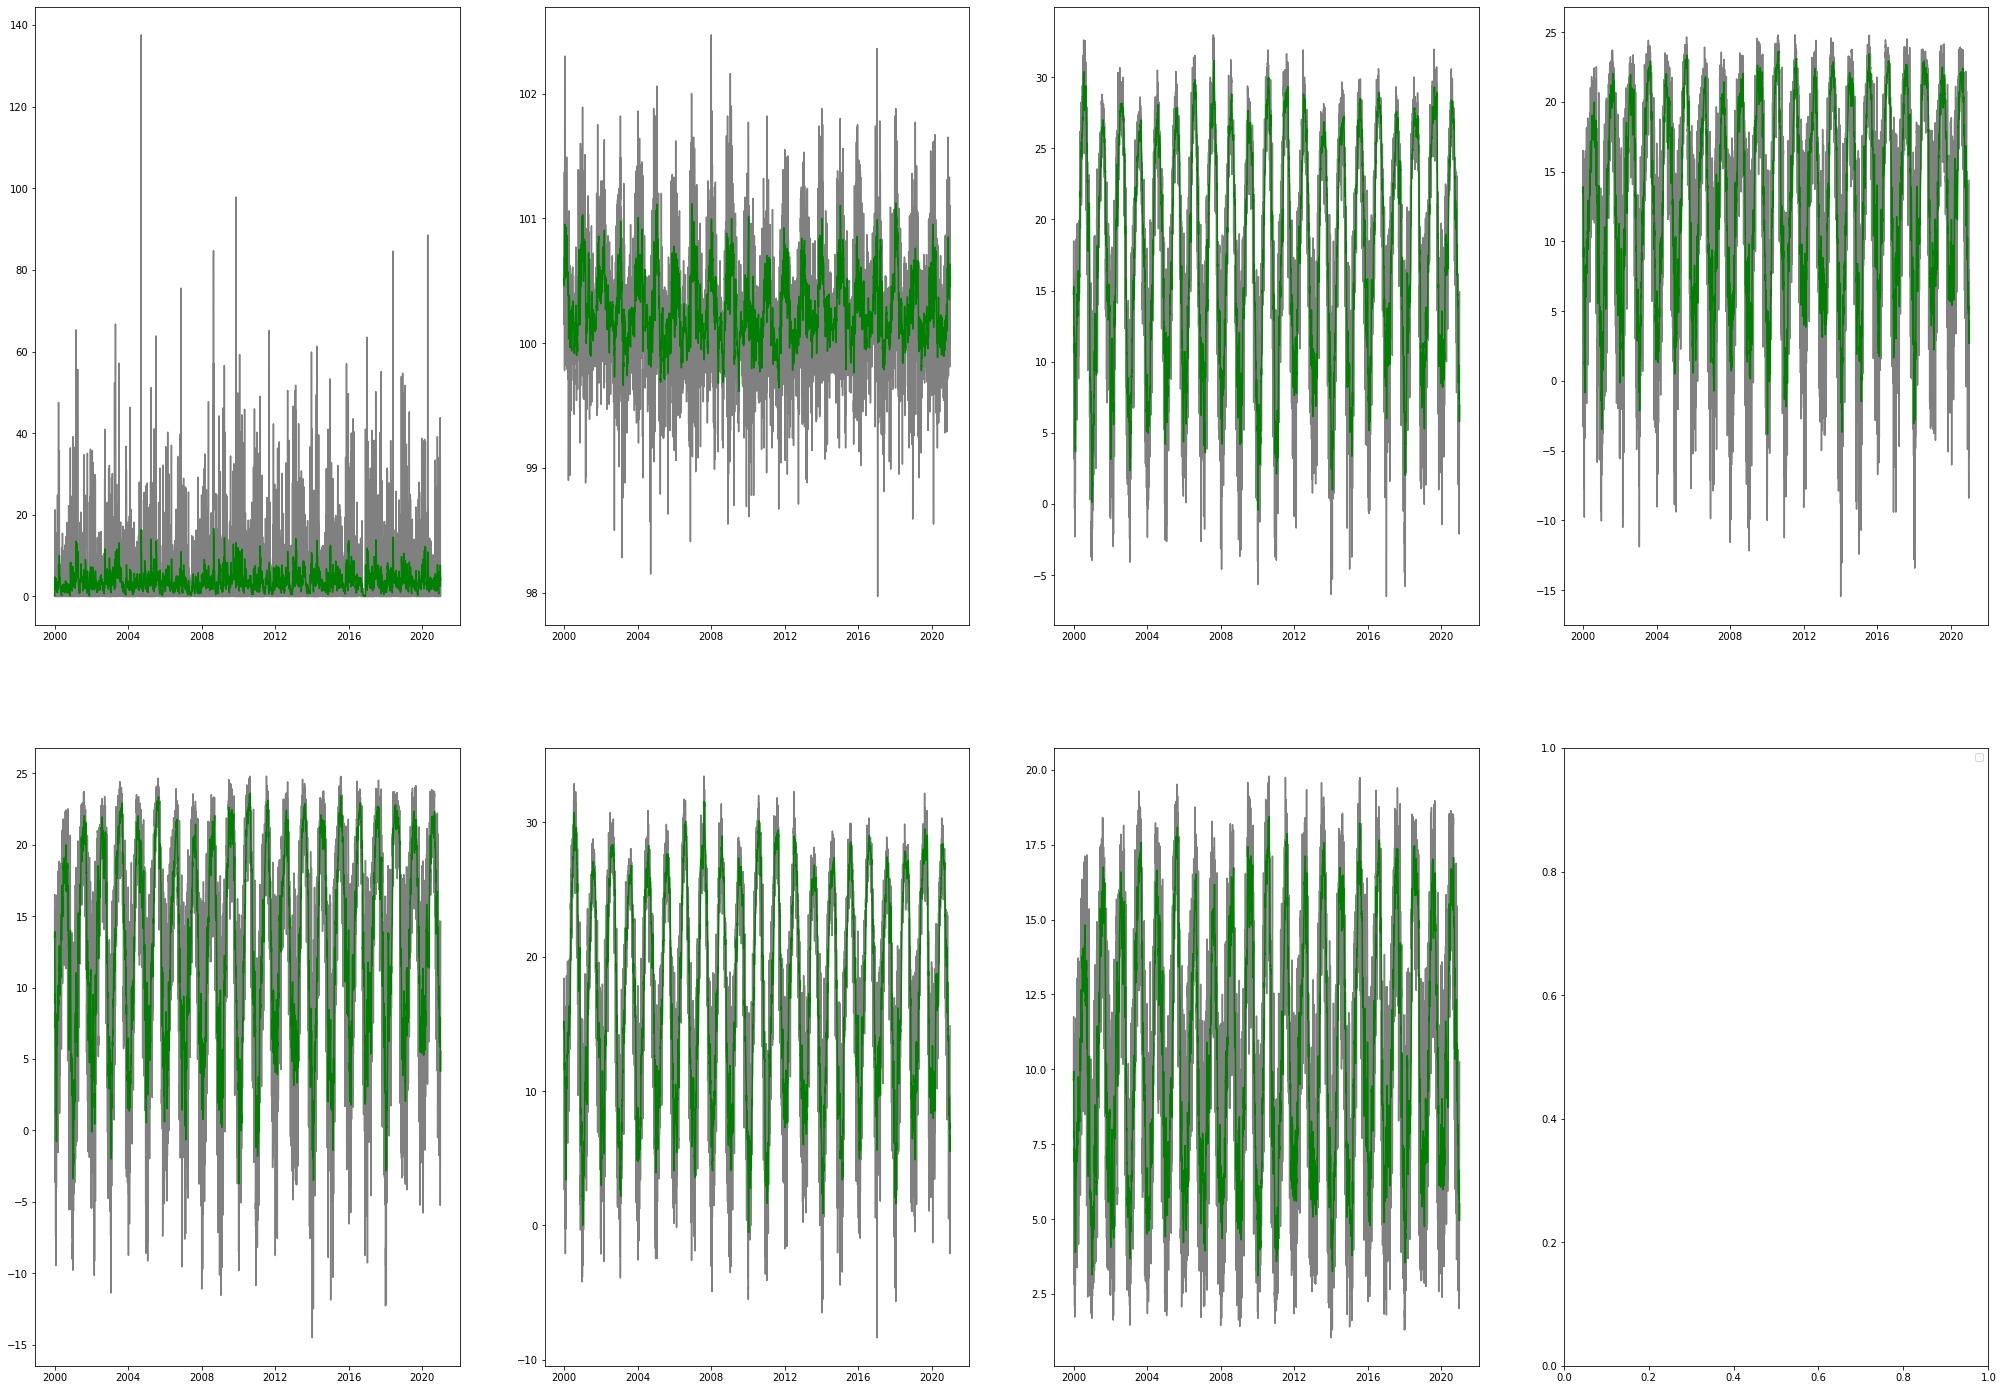

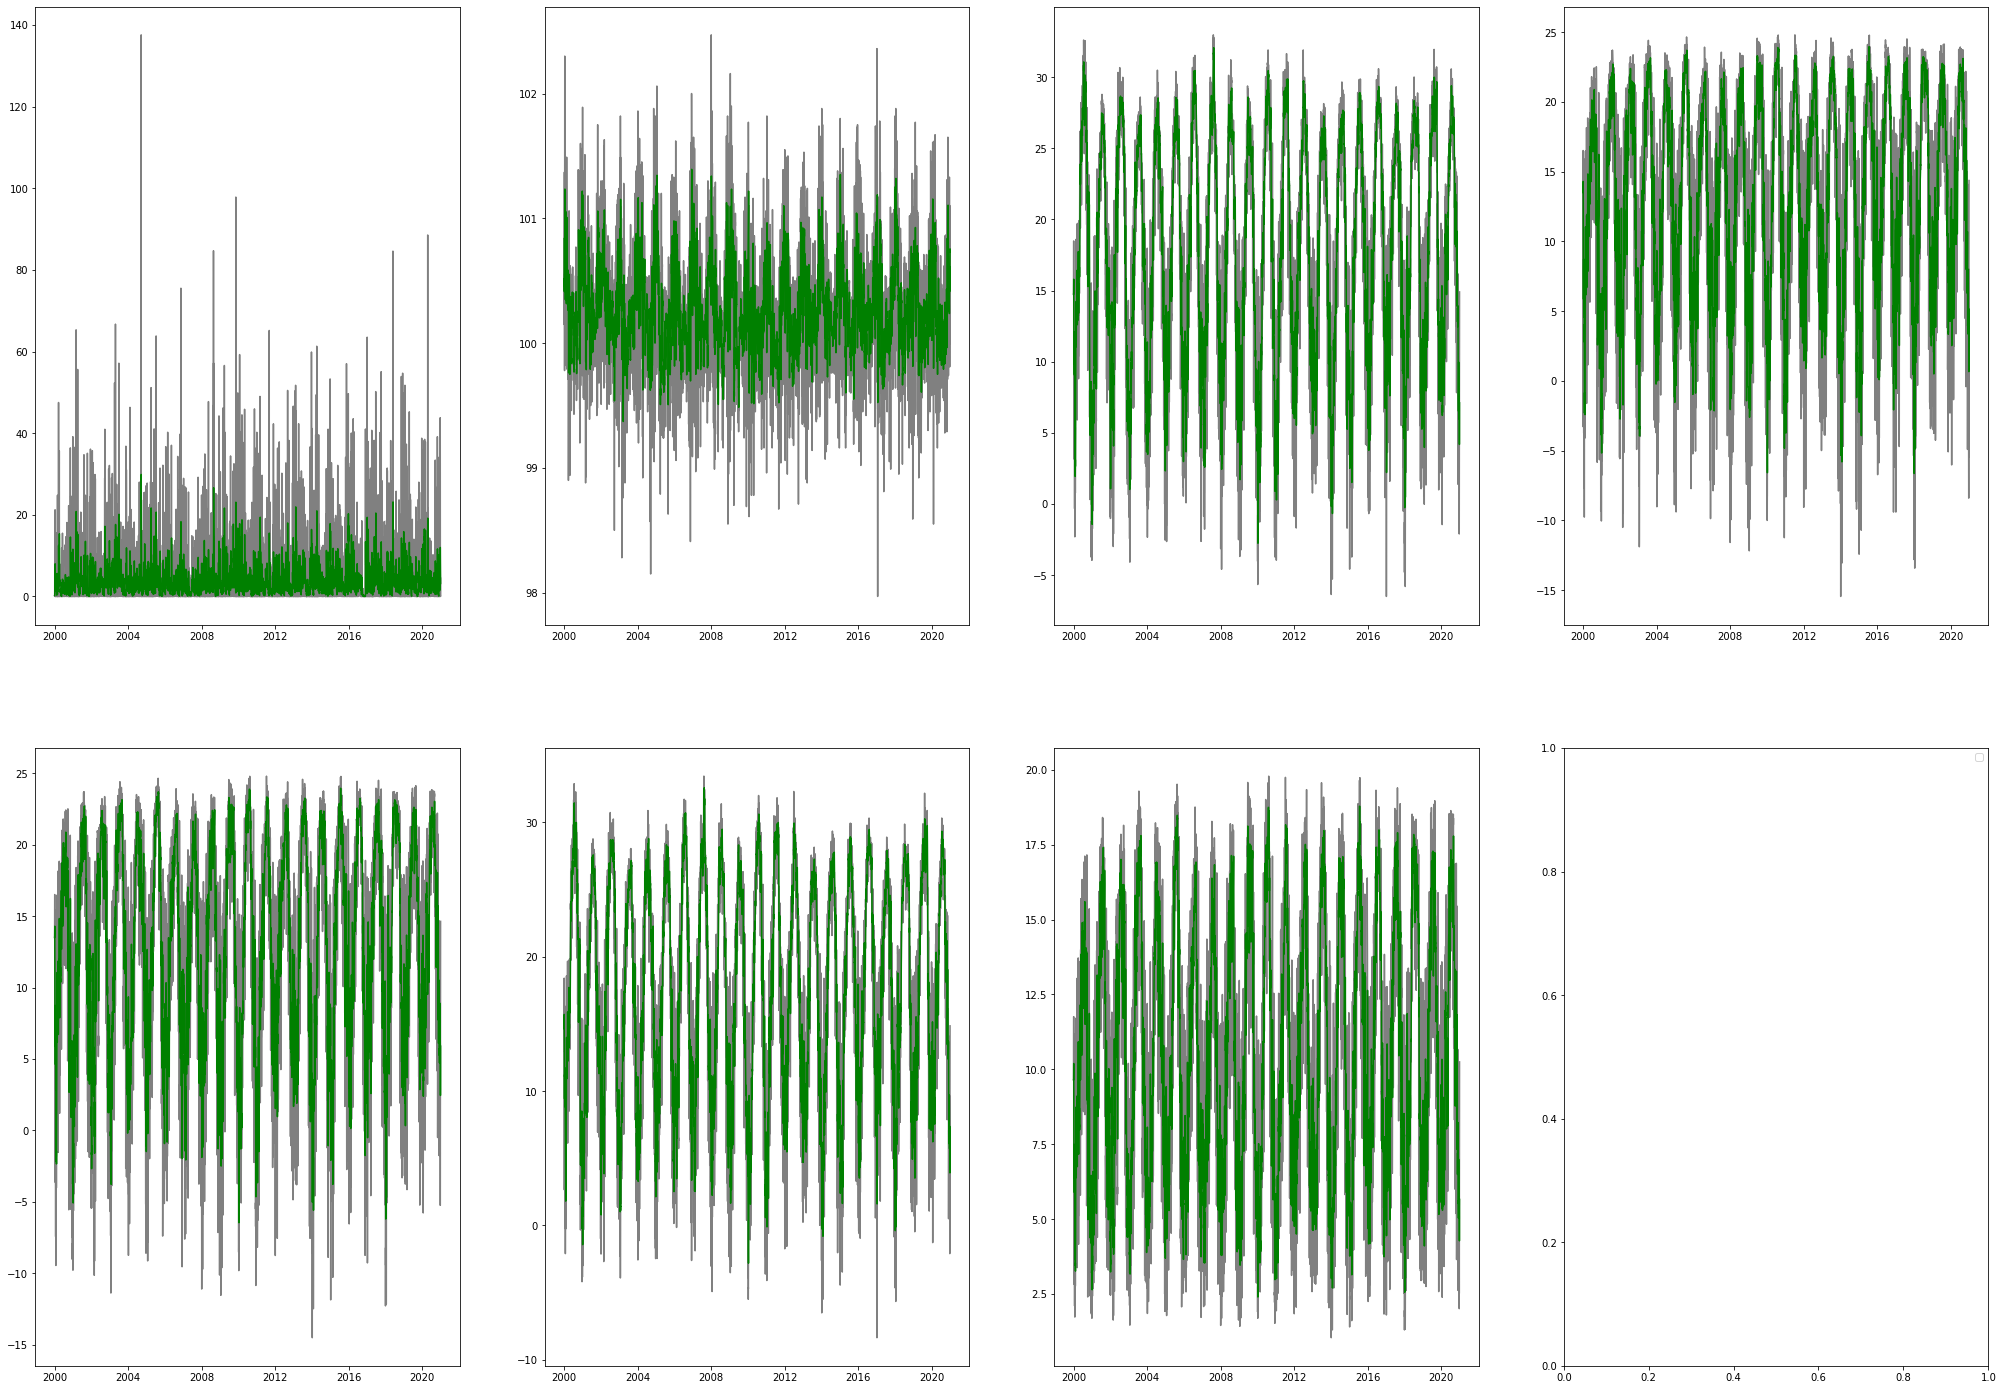

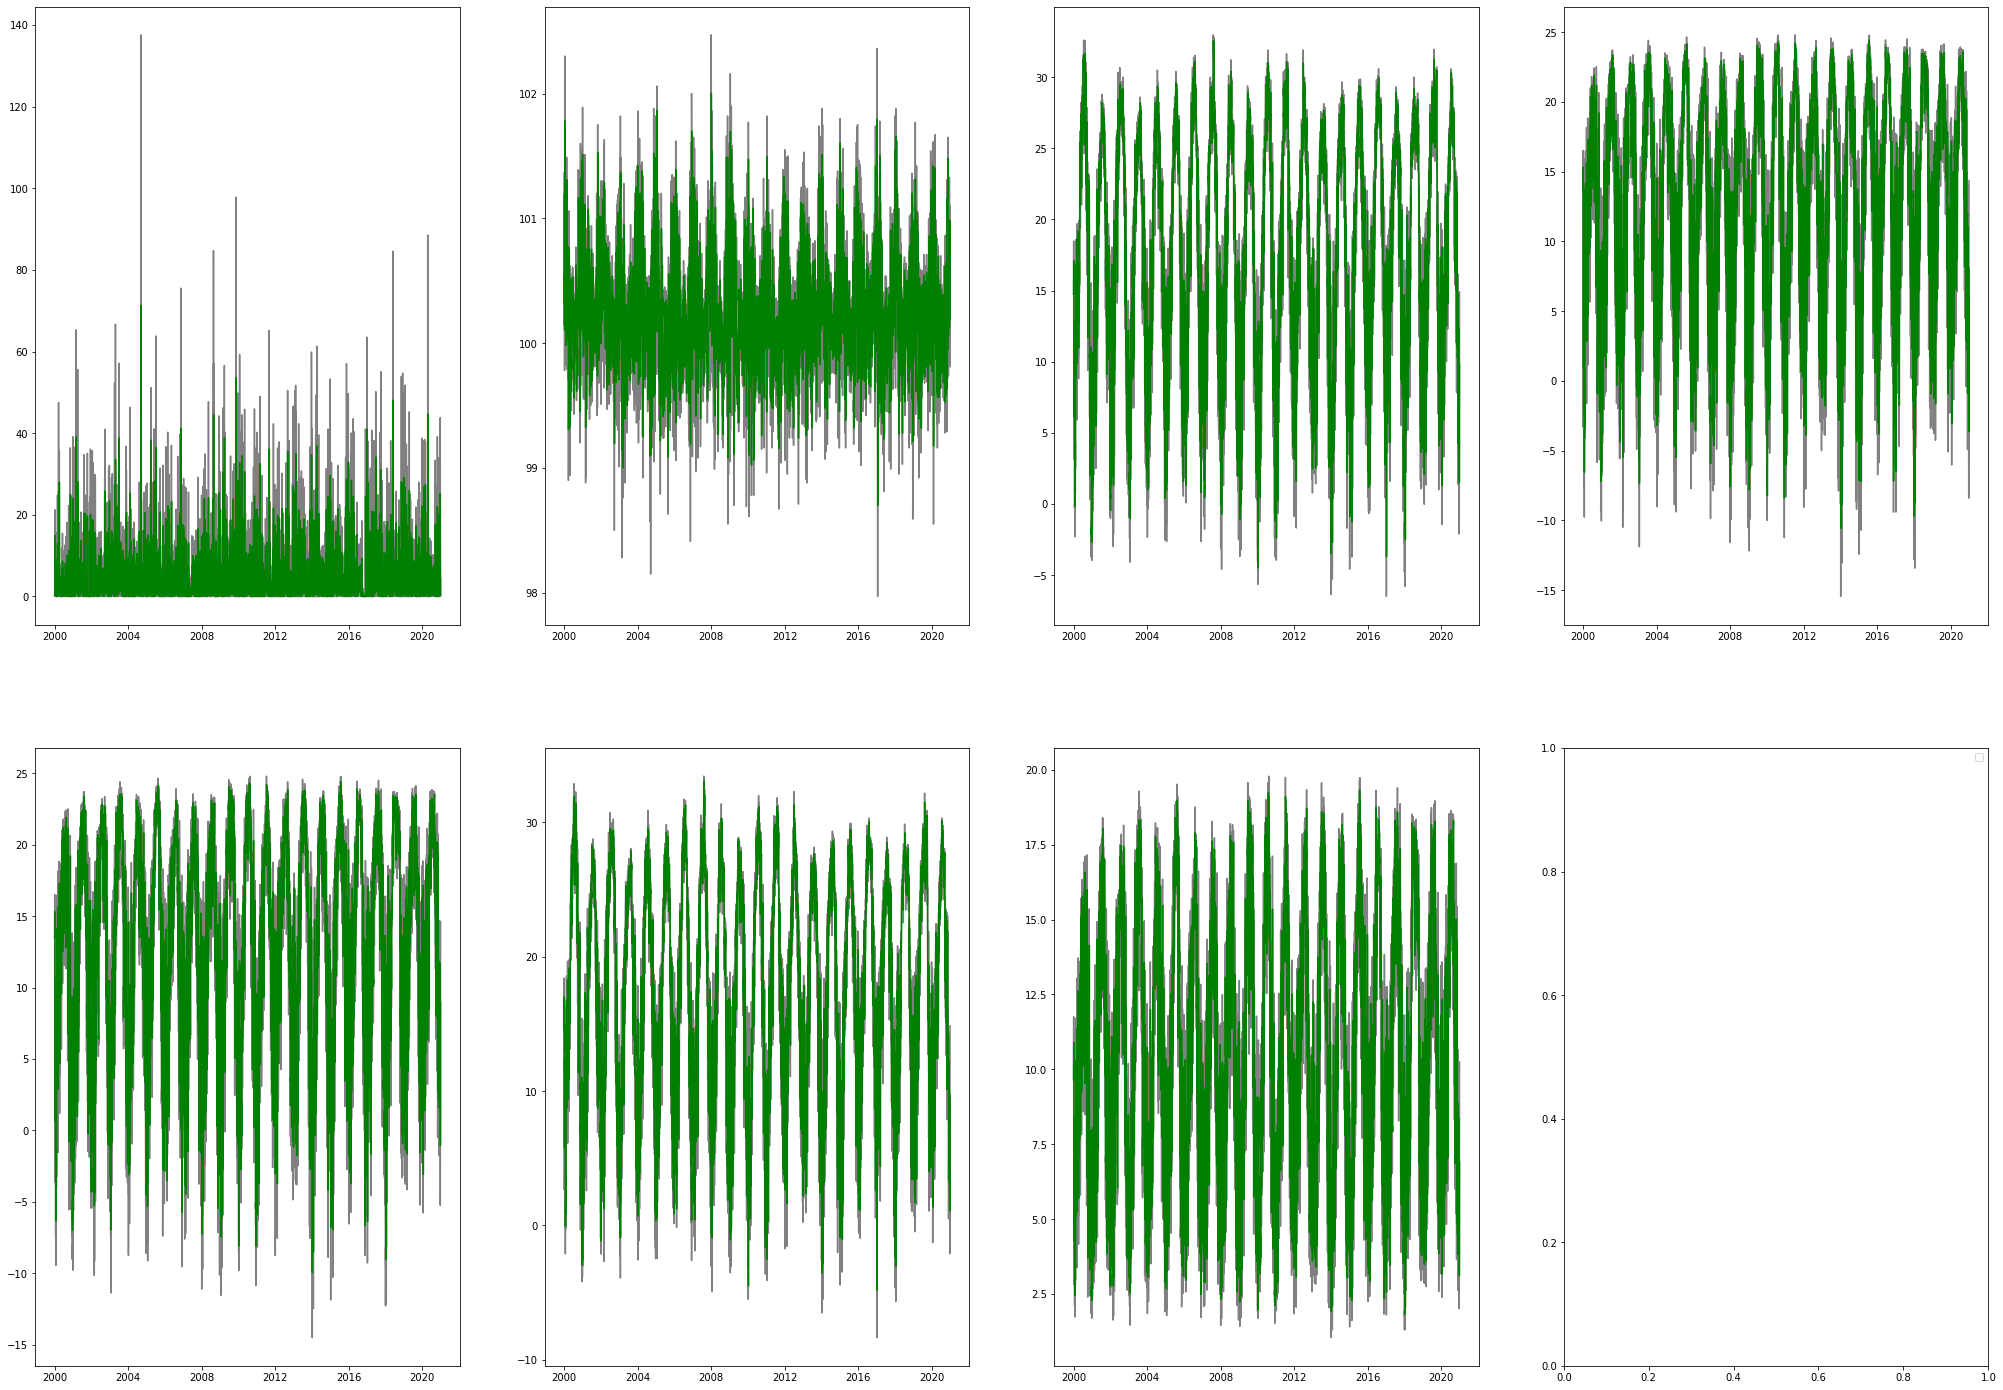

In [63]:
data_smooth_frac001 = smooth_sg1(daily_data, 0.01, 3, 'drought_forecasting_smoothing_frac001_p3',(2, 4))
data_smooth_frac005 = smooth_sg1(daily_data, 0.05, 3, 'drought_forecasting_smoothing_frac005_p3',(2, 4))
data_smooth_frac01 = smooth_sg1(daily_data, 0.1, 3, 'drought_forecasting_smoothing_frac01_p3',(2, 4))

data_smooth_ses_01 = ses(daily_data, 0.1, 'drought_forecasting_smoothing_ses_01', (2,4))
data_smooth_ses_02 = ses(daily_data, 0.2, 'drought_forecasting_smoothing_ses_02', (2,4))
data_smooth_ses_05 = ses(daily_data, 0.5, 'drought_forecasting_smoothing_ses_05', (2,4))

pers_res = pd.DataFrame(columns=['col', 'rmse_savgol_01', 'rmse_savgol_05', 'rmse_savgol_1', 'rmse_SimpleExp_1', 'rmse_SimpleExp_2', 'rmse_SimpleExp_5'])

for col in range(len(daily_data.columns)):

    X_train_0, X_test_0, Y_train_0, Y_test_0 = temporal_data_split_forPersistence(data_smooth_frac001[col])
    X_train_1, X_test_1, Y_train_1, Y_test_1 = temporal_data_split_forPersistence(data_smooth_frac005[col])
    X_train_2, X_test_2, Y_train_2, Y_test_2 = temporal_data_split_forPersistence(data_smooth_frac01[col])

    X_train_3, X_test_3, Y_train_3, Y_test_3 = temporal_data_split_forPersistence(data_smooth_ses_01[col])
    X_train_4, X_test_4, Y_train_4, Y_test_4 = temporal_data_split_forPersistence(data_smooth_ses_02[col])
    X_train_5, X_test_5, Y_train_5, Y_test_5 = temporal_data_split_forPersistence(data_smooth_ses_05[col])


    res_ps_0, rmse_ps_0 = persistence_model(X_test_0, Y_test_0)
    res_ps_1, rmse_ps_1 = persistence_model(X_test_1, Y_test_1)
    res_ps_2, rmse_ps_2 = persistence_model(X_test_2, Y_test_2)

    res_ps_3, rmse_ps_3 = persistence_model(X_test_3, Y_test_3)
    res_ps_4, rmse_ps_4 = persistence_model(X_test_4, Y_test_4)
    res_ps_5, rmse_ps_5 = persistence_model(X_test_5, Y_test_5)


    pers_res.loc[col] = [daily_data.columns[col], rmse_ps_0, rmse_ps_1, rmse_ps_2, rmse_ps_3, rmse_ps_4, rmse_ps_5]


In [64]:
pers_res = pers_res.transpose()
pers_res.columns = pers_res.iloc[0]
pers_res

col,PRECTOT,PS,T2M,T2MDEW,T2MWET,TS,QV2M
col,PRECTOT,PS,T2M,T2MDEW,T2MWET,TS,QV2M
rmse_savgol_01,0.247957,0.015152,0.189802,0.193772,0.192116,0.191497,0.109324
rmse_savgol_05,0.044032,0.003786,0.106628,0.092589,0.090441,0.108156,0.057715
rmse_savgol_1,0.020541,0.001307,0.02703,0.024857,0.024585,0.027306,0.014892
rmse_SimpleExp_1,0.855978,0.044733,0.391663,0.486786,0.482982,0.392696,0.260861
rmse_SimpleExp_2,1.73643,0.086821,0.715607,0.927025,0.919302,0.716198,0.491427
rmse_SimpleExp_5,4.560289,0.202569,1.593666,2.1478,2.127478,1.593237,1.129225


In [505]:
# choice: simple exponential smoothing with level = 0.1
data_pos_smoothing = pd.DataFrame(data_smooth_ses_01)
data_pos_smoothing = data_pos_smoothing.transpose()
data_pos_smoothing = data_pos_smoothing.rename(columns = {0:"PRECTOT", 1:"PS", 2:"T2M", 3:"T2MDEW", 4:"T2MWET", 5:"TS", 6:"QV2M"})
data_pos_smoothing

,PRECTOT,PS,T2M,T2MDEW,T2MWET,TS,QV2M
date,,,,,,,
2000-01-01,0.220000,100.510000,14.740000,13.510000,13.510000,14.650000,9.650000
2000-01-02,0.220000,100.510000,14.740000,13.510000,13.510000,14.650000,9.650000
2000-01-03,0.218000,100.514000,14.935000,13.630000,13.630000,14.845000,9.727000
2000-01-04,0.561200,100.477600,15.290500,13.919000,13.919000,15.201500,9.930300
2000-01-05,2.100080,100.458840,14.901450,13.136100,13.137100,14.812350,9.579270
...,...,...,...,...,...,...,...
2020-12-27,6.221973,100.504567,6.041217,2.884540,4.344070,5.760732,5.047313
2020-12-28,5.599776,100.527110,5.787096,2.683086,4.127663,5.516659,4.945581
2020-12-29,5.044798,100.581399,5.928386,3.053777,4.394897,5.659993,5.046023


In [486]:
# differenciation

# one differenciation
data_one_diff = data_pos_smoothing.diff(axis = 0, periods = 1)
# two differenciation
data_two_diff = data_pos_smoothing.diff(axis = 0, periods = 1)
data_two_diff = data_two_diff.diff(axis = 0, periods = 1)

In [487]:
data_one_diff = data_one_diff.iloc[1:,:]
data_two_diff = data_two_diff.iloc[2:,:]

In [497]:
res_diff = pd.DataFrame(columns=['col', 'rmse_oneDiff', 'rmse_twoDiff', 'rmse_noDiff'])

for col in range(len(data_one_diff.columns)):

    X_train_oneDiff, X_test_oneDiff, Y_train_oneDiff, Y_test_oneDiff = temporal_data_split_forPersistence(data_one_diff.iloc[:,col])
    X_train_twoDiff, X_test_twoDiff, Y_train_twoDiff, Y_test_twoDiff = temporal_data_split_forPersistence(data_two_diff.iloc[:,col])
    X_train_noDiff, X_test_noDiff, Y_train_noDiff, Y_test_noDiff = temporal_data_split_forPersistence(data_pos_smoothing.iloc[:,col])

    res_oneDiff, rmse_oneDiff = persistence_model(X_test_oneDiff, Y_test_oneDiff)
    res_twoDiff, rmse_twoDiff = persistence_model(X_test_twoDiff, Y_test_twoDiff)
    res_noDiff, rmse_noDiff = persistence_model(X_test_noDiff, Y_test_noDiff)
    
    res_diff.loc[col] = [col, rmse_oneDiff, rmse_twoDiff, rmse_noDiff]

X_train_noDiff, X_test_noDiff, Y_train_noDiff, Y_test_noDiff = temporal_data_split_forPersistence(data_one_diff.iloc[:,col])

In [498]:
res_diff

,col,rmse_oneDiff,rmse_twoDiff,rmse_noDiff
0,0.0,1.091535,1.798757,0.855978
1,1.0,0.038565,0.049892,0.044733
2,2.0,0.299190,0.392372,0.391663
3,3.0,0.415706,0.557233,0.486786
4,4.0,0.411401,0.551193,0.482982
5,5.0,0.298398,0.389629,0.392696
6,6.0,0.220690,0.302432,0.260861
